In [1]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

## Assignment

Make a performance evaluation of the 18 Danish globally oriented mutual funds shown
below based on monthly net excess returns over the period 2000:12 to 2010:11. $rm$ denotes the excess return on the MSCI World Index. The returns are measured in excess of the
1-month CIBOR rate. $smb$ and $hml$ denote the Fama-French small-minus-big and high-minus-low factors obtained from Kenneth French's data library for developed markets.
Except for $smb$ and $hml$, the data corresponds to the data used in the Matlab program
already available on Blackboard. Consequently, the problems are a natural extension of
the performance evaluation performed in that program and you can solve the problems
in this problem set by making prober adjustments of the already provided program.


### Problem 1



Evaluate the performance of the mutual funds using the Fama-French 3 -factor
benchmark model
$$
R_{i t}-R_{f t}=\alpha_{i}+b_{i}\left(R_{M t}-R_{f t}\right)+s_{i} S M B_{t}+h_{i} H M L_{t}+\varepsilon_{i t}, \quad i=1, \ldots, 18
$$
where $R_{i t}-R_{f t}$ denotes the excess return on the $i$ 'th mutual fund, $R_{M t}-R_{f t}$
the excess return on the MSCI World Index, $S M B_{t}$ the small-minus-big factor,
and $H M L_{t}$ the high-minus-low factor. Report the estimated coefficients, relevant $t$ -statistics and the $R^{2}$ values. Furthermore, implement the bootstrap procedure by
Kosowski et al. (2006) using the Fama-French 3-factor model. Compare the results
to those using only the CAPM as benchmark model.

In [2]:
df = pd.read_excel('Data.xlsx')

df.head()

,date,rw,smb,hml,m_1,m_2,m_3,m_4,m_5,m_6,...,m_9,m_10,m_11,m_12,m_13,m_14,m_15,m_16,m_17,m_18
0,2000-12-01,-0.062901,0.0051,0.0765,-0.043547,-0.050653,-0.078606,-0.058811,-0.069896,-0.060835,...,-0.078511,-0.057712,-0.046685,-0.044166,-0.069057,-0.061370,-0.056057,-0.026283,-0.063375,-0.071145
1,2001-01-01,0.024278,0.0270,-0.0386,0.055258,0.019085,-0.024483,0.029512,0.007341,0.020362,...,0.029941,0.019225,0.052337,0.002300,0.057975,0.038095,0.023081,0.079393,0.063165,0.020137
2,2001-02-01,-0.080998,0.0220,0.1181,-0.103060,-0.099124,-0.080192,-0.115012,-0.099275,-0.111115,...,-0.119531,-0.080411,-0.102112,-0.067693,-0.133843,-0.092397,-0.071751,-0.061451,-0.018371,-0.104762
3,2001-03-01,-0.031962,-0.0083,0.0714,-0.033114,-0.040262,-0.042665,-0.064560,-0.038666,-0.071563,...,-0.048347,-0.036382,-0.061714,-0.043062,-0.081413,-0.047008,-0.030968,-0.071701,-0.062655,-0.024842
4,2001-04-01,0.063589,-0.0062,-0.0321,0.066025,0.070931,0.019006,0.079109,0.062309,0.080136,...,0.077434,0.077334,0.053822,0.079308,0.097179,0.068578,0.071110,0.082487,0.072158,0.062593


In [3]:
# funds
funds = [i for i in df.columns if i not in ['date', 'rw', 'hml', 'smb']]

# seed random numbers
np.random.seed(5)

# number of bootstraps
m = 10000

# number of funds
n = df[funds].shape[1]

# number of timeseries observations
T = df[funds].shape[0]

In [4]:
# Annualize all returns (smart for interpreting alpha also as annual abnormal return)
df[[i for i in df.columns if i != 'date']] = df[[i for i in df.columns if i != 'date']] * 12 * 100
#df = df.sort_index(ascending=True)

df.head()

,date,rw,smb,hml,m_1,m_2,m_3,m_4,m_5,m_6,...,m_9,m_10,m_11,m_12,m_13,m_14,m_15,m_16,m_17,m_18
0,2000-12-01,-75.481071,6.12,91.80,-52.256347,-60.783436,-94.327374,-70.573293,-83.875028,-73.002127,...,-94.212902,-69.254246,-56.021878,-52.999669,-82.867895,-73.644195,-67.268803,-31.540056,-76.050218,-85.373447
1,2001-01-01,29.133088,32.40,-46.32,66.309652,22.902110,-29.380049,35.413926,8.809407,24.434798,...,35.929070,23.069831,62.804564,2.760122,69.570504,45.714146,27.696676,95.271813,75.797447,24.164457
2,2001-02-01,-97.197807,26.40,141.72,-123.672327,-118.949342,-96.230543,-138.014407,-119.130209,-133.337842,...,-143.436928,-96.493524,-122.533991,-81.231589,-160.612191,-110.875901,-86.101145,-73.741501,-22.044730,-125.714885
3,2001-03-01,-38.354735,-9.96,85.68,-39.736548,-48.314297,-51.198433,-77.472128,-46.399321,-85.876090,...,-58.016789,-43.658833,-74.056623,-51.674076,-97.696171,-56.410086,-37.161143,-86.041550,-75.185636,-29.810001
4,2001-04-01,76.306515,-7.44,-38.52,79.230276,85.117668,22.807274,94.930342,74.770654,96.162642,...,92.920735,92.801244,64.586201,95.169347,116.614396,82.294116,85.332133,98.984437,86.589192,75.112193


#### Fitting the model

Now we fit the model for each fund $i$ in the dataset.

$$
R_{i t}-R_{f t}=\alpha_{i}+b_{i}\left(R_{M t}-R_{f t}\right)+s_{i} S M B_{t}+h_{i} H M L_{t}+\varepsilon_{i t}, \quad i=1, \ldots, 18
$$

In [5]:
results = []  # list of dictionaries
bootstrap_alpha = {}

for fund in funds:
    print(fund)
    
    Y = df[fund]
    X = df[['rw', 'smb', 'hml']]
    X = sm.add_constant(X)

    mdlFit = sm.OLS(endog=Y, exog=X).fit()
    res = mdlFit.params.to_dict()

    # save all parameters and t-stats
    res['fund'] = fund
    res['T: b=1'] = (res['rw'] - 1) / mdlFit.bse['rw']
    res['T: a=0'] = (res['const']) / mdlFit.bse['const']
    res['T: s=0'] = (res['smb']) / mdlFit.bse['smb']
    res['T: h=0'] = (res['hml']) / mdlFit.bse['hml']
    res['R2'] = mdlFit.rsquared

    results.append(res)

    resid = mdlFit.resid

    bootstrap_alpha[fund] = []

    for bootstrap in range(m):
        resid_boot = np.random.choice(resid, T, replace=True)
        mf_boot = 0 + res['rw']*df['rw'] + res['smb']*df['smb'] + res['hml']*df['hml'] + resid_boot

        mdlFit = sm.OLS(endog=mf_boot, exog=X).fit()

        bootstrap_alpha[fund].append(mdlFit.params['const'])



results = pd.DataFrame(results).set_index('fund')
bootstrap_alpha = pd.DataFrame(bootstrap_alpha)

display(results.head())
display(bootstrap_alpha.head())

m_1
m_2
m_3
m_4
m_5
m_6
m_7
m_8
m_9
m_10
m_11
m_12
m_13
m_14
m_15
m_16
m_17
m_18


,const,rw,smb,hml,T: b=1,T: a=0,T: s=0,T: h=0,R2
fund,,,,,,,,,
m_1,2.600673,1.009852,0.225872,-0.118524,0.388643,1.805961,3.545340,-2.321412,0.937241
m_2,-1.980513,0.971495,0.115698,-0.134911,-0.944693,-1.155415,1.525670,-2.219889,0.906957
m_3,0.739767,0.868688,0.079040,-0.058657,-3.217647,0.319097,0.770639,-0.713628,0.806871
m_4,1.000358,1.023595,0.148122,-0.155019,0.892527,0.666116,2.229401,-2.911415,0.934056
m_5,-1.018003,0.989482,-0.056027,-0.059627,-1.398960,-2.383419,-2.964967,-3.937476,0.993749


,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,m_13,m_14,m_15,m_16,m_17,m_18
0,-1.220187,0.213527,-1.625448,3.361215,0.392994,1.566656,-0.556933,1.618657,2.748653,-0.705945,0.528853,-0.256869,2.254540,0.673658,-0.900091,2.131121,0.656581,-0.698436
1,1.077251,-0.770615,2.403075,-0.536692,-0.113659,-1.491550,-0.149135,3.061192,0.699695,2.237364,-1.584572,2.323778,3.691070,1.937355,-1.130485,-2.848294,-1.508924,0.679454
2,-1.085272,-0.807614,-0.165552,1.761284,0.108545,-1.882864,-0.407097,0.334050,-0.095982,2.202751,-3.585642,-0.911836,-0.181898,-0.323230,0.449593,-3.251120,-4.305763,-0.722395
3,1.361050,0.827723,-0.263445,3.703263,-0.030971,1.527092,-0.721920,-0.937019,1.463179,-0.347670,2.357032,0.157710,3.363593,-0.395445,1.872362,-2.175591,-0.827276,-0.969480
4,-0.064740,0.485143,0.255705,-1.197076,0.228790,-0.038943,0.025496,0.797287,0.742413,4.521508,0.823934,0.428216,3.261905,1.214308,-0.097648,0.642787,-3.157721,-0.070801


In [6]:
bootstrap_alpha_s = bootstrap_alpha.values.transpose()
bootstrap_alpha_s = np.sort(bootstrap_alpha_s, axis=0)

# print first column
bootstrap_alpha_s[:,0]

array([-1.62544831, -1.2201873 , -0.90009131, -0.7059447 , -0.69843583,
       -0.55693335, -0.25686935,  0.21352655,  0.39299383,  0.52885287,
        0.65658068,  0.67365753,  1.56665574,  1.6186566 ,  2.13112131,
        2.25454012,  2.7486534 ,  3.36121524])

In [7]:
alpha_s = results['const'].sort_values()
idx = alpha_s.index

alpha_s = alpha_s.to_numpy()

In [8]:
cv_05 = np.quantile(bootstrap_alpha_s, 0.05, axis=1)
cv_95 = np.quantile(bootstrap_alpha_s, 0.95, axis=1)

cv_05


display(cv_95)

array([-1.47164546, -0.96849918, -0.63485549, -0.38770032, -0.18778851,
       -0.00906072,  0.16271983,  0.32949475,  0.51422181,  0.70375552,
        0.91134376,  1.13979992,  1.40863299,  1.72784255,  2.13956406,
        2.64919775,  3.5622523 ,  6.28871159])

In [9]:
cvs = pd.DataFrame([cv_05, cv_95]).transpose()

cvs['fund'] = idx

cvs = cvs.rename(columns={0: 'CV_05', 1: 'CV_95'})

cvs = cvs.set_index('fund')

results = results.join(cvs)

results

,const,rw,smb,hml,T: b=1,T: a=0,T: s=0,T: h=0,R2,CV_05,CV_95
fund,,,,,,,,,,,
m_1,2.600673,1.009852,0.225872,-0.118524,0.388643,1.805961,3.545340,-2.321412,0.937241,0.648522,2.649198
m_2,-1.980513,0.971495,0.115698,-0.134911,-0.944693,-1.155415,1.525670,-2.219889,0.906957,-2.703891,-0.634855
m_3,0.739767,0.868688,0.079040,-0.058657,-3.217647,0.319097,0.770639,-0.713628,0.806871,0.009891,1.408633
m_4,1.000358,1.023595,0.148122,-0.155019,0.892527,0.666116,2.229401,-2.911415,0.934056,0.183693,1.727843
m_5,-1.018003,0.989482,-0.056027,-0.059627,-1.398960,-2.383419,-2.964967,-3.937476,0.993749,-0.499221,0.703756
m_6,-0.062675,0.996857,0.257847,-0.210425,-0.114612,-0.040230,3.741052,-3.809604,0.927527,-0.161415,1.139800
m_7,-1.133399,1.006410,-0.000197,-0.067031,0.557858,-1.736280,-0.006829,-2.896270,0.986022,-0.891175,0.329495
m_8,-1.619074,1.058636,-0.120307,-0.164369,2.602689,-1.265076,-2.124779,-3.622385,0.954125,-1.719313,-0.187789
m_9,1.282343,1.062184,0.178649,-0.310822,2.311781,0.839206,2.642645,-5.737190,0.939012,0.396441,2.139564


In [10]:
names = ['Bank Invest',
         'Alm.Brand Invest',
         'Carnegie World Wide',
         'Danske Invest Global Indeks',
         'Danske Invest Global Indeks 2',
         'Danske Invest Global Stockpicking',
         'Danske Invest Global Stockpicking 2',
         'Handelsinvest',
         'Jyske Invest Globale Aktier',
         'Laan og Spar Invest',
         'Nordea Invest Aktier',
         'Nordea Invest Aktier II',
         'Nordea Invest Global Vaekst',
         'Nordea Invest Verden',
         'Nykredit Invest',
         'Skagen Global',
         'Skagen Vaekst',
         'Sydinvest']

results.index.name = None

idx_map = {results.index[i]: j for i, j in enumerate(names)}
results.index = results.index.map(idx_map)
results = results.rename(columns={'const': 'alpha'})

results.head()

,alpha,rw,smb,hml,T: b=1,T: a=0,T: s=0,T: h=0,R2,CV_05,CV_95
Bank Invest,2.600673,1.009852,0.225872,-0.118524,0.388643,1.805961,3.545340,-2.321412,0.937241,0.648522,2.649198
Alm.Brand Invest,-1.980513,0.971495,0.115698,-0.134911,-0.944693,-1.155415,1.525670,-2.219889,0.906957,-2.703891,-0.634855
Carnegie World Wide,0.739767,0.868688,0.079040,-0.058657,-3.217647,0.319097,0.770639,-0.713628,0.806871,0.009891,1.408633
Danske Invest Global Indeks,1.000358,1.023595,0.148122,-0.155019,0.892527,0.666116,2.229401,-2.911415,0.934056,0.183693,1.727843
Danske Invest Global Indeks 2,-1.018003,0.989482,-0.056027,-0.059627,-1.398960,-2.383419,-2.964967,-3.937476,0.993749,-0.499221,0.703756


In [11]:
def check_significance(alpha, cv0, cv1):
    if alpha < cv0:
        return 1
    elif alpha > cv1:
        return 2
    else:
        return 0


results['sig'] = results.apply(lambda x: check_significance(x['alpha'], x['CV_05'], x['CV_95']), axis=1)
results

,alpha,rw,smb,hml,T: b=1,T: a=0,T: s=0,T: h=0,R2,CV_05,CV_95,sig
Bank Invest,2.600673,1.009852,0.225872,-0.118524,0.388643,1.805961,3.545340,-2.321412,0.937241,0.648522,2.649198,0
Alm.Brand Invest,-1.980513,0.971495,0.115698,-0.134911,-0.944693,-1.155415,1.525670,-2.219889,0.906957,-2.703891,-0.634855,0
Carnegie World Wide,0.739767,0.868688,0.079040,-0.058657,-3.217647,0.319097,0.770639,-0.713628,0.806871,0.009891,1.408633,0
Danske Invest Global Indeks,1.000358,1.023595,0.148122,-0.155019,0.892527,0.666116,2.229401,-2.911415,0.934056,0.183693,1.727843,0
Danske Invest Global Indeks 2,-1.018003,0.989482,-0.056027,-0.059627,-1.398960,-2.383419,-2.964967,-3.937476,0.993749,-0.499221,0.703756,1
Danske Invest Global Stockpicking,-0.062675,0.996857,0.257847,-0.210425,-0.114612,-0.040230,3.741052,-3.809604,0.927527,-0.161415,1.139800,0
Danske Invest Global Stockpicking 2,-1.133399,1.006410,-0.000197,-0.067031,0.557858,-1.736280,-0.006829,-2.896270,0.986022,-0.891175,0.329495,1
Handelsinvest,-1.619074,1.058636,-0.120307,-0.164369,2.602689,-1.265076,-2.124779,-3.622385,0.954125,-1.719313,-0.187789,0
Jyske Invest Globale Aktier,1.282343,1.062184,0.178649,-0.310822,2.311781,0.839206,2.642645,-5.737190,0.939012,0.396441,2.139564,0
Laan og Spar Invest,-2.215031,0.932535,-0.057857,-0.120494,-2.604204,-1.505123,-0.888636,-2.309301,0.923714,-3.638928,-0.968499,0


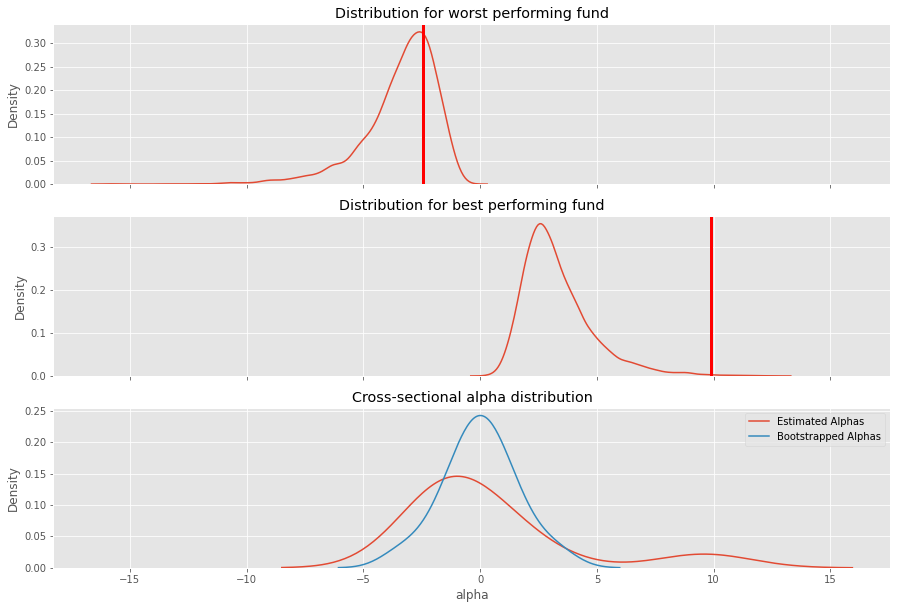

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=(15,10))

sns.kdeplot(bootstrap_alpha_s[0], ax=ax[0])  # worst fund
sns.kdeplot(bootstrap_alpha_s[-1], ax=ax[1])  # best fund

sns.kdeplot('alpha', data=results, ax=ax[2], label='Estimated Alphas')
sns.kdeplot(pd.DataFrame(bootstrap_alpha_s).mean(axis=1), ax=ax[2], label='Bootstrapped Alphas')

ax[0].axvline(results['alpha'].sort_values().iloc[0], color='red', linewidth=3)
ax[1].axvline(results['alpha'].sort_values().iloc[-1], color='red', linewidth=3)


results['alpha'].sort_values().iloc[0]
results['alpha'].sort_values().iloc[-1]


ax[2].legend()

ax[0].set_title('Distribution for worst performing fund')
ax[1].set_title('Distribution for best performing fund')
ax[2].set_title('Cross-sectional alpha distribution')

plt.show()